In [111]:
from __future__ import division
import cPickle as pkl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [112]:
import warnings
warnings.filterwarnings('ignore')

# Load matched samples

In [113]:
matched_df = pd.read_csv('../tmp/learning_tasks/METONLY_vs_METAFTER/matched_CEM_table.csv', header=0, index_col=0)
print(matched_df.head())
print(matched_df.shape)

              AVG_AGE SEX PINSTATE  SEQ_LENGTH  CLASS
4106989574  49.937220   F  ACT+NSW         445      1
3416643592  62.809322   F      QLD         471      1
895586988   54.787709   F      QLD         127      1
815892493   53.303030   M  VIC+TAS         131      1
167198734   79.793750   F  ACT+NSW         319      1
(4906, 5)


# Load raw data

In [114]:
def load_data(dump_files):
    """Extract sequences, extra info and patient id from dump pkl."""
    # Positive raw data load
    raw_data = []
    extra_info = []
    indexes = []
    for f in tqdm(dump_files, desc='Loading dump files'):
        _tmp = pkl.load(open(os.path.join('..', 'tmp', f), 'rb'))
        _raw_data, _extra_info = _tmp['raw_data'], _tmp['extra_info']
        for k in _extra_info.index:
            if len(_raw_data[k])>0: # Skip empty sequences
                raw_data.append(_raw_data[k])
                extra_info.append([_extra_info.loc[k]['SEX'], _extra_info.loc[k]['AGE']])
                indexes.append(k)
    return raw_data, extra_info, indexes

In [115]:
dump_files = filter(lambda x: 'raw_data' in x, os.listdir('../tmp/'))
positive_dump_files = filter(lambda x: 'METAFTER' in x, dump_files)
negative_dump_files = filter(lambda x: 'METONLY' in x, dump_files)
# negative_dump_files = filter(lambda x: 'METONLY' in x, dump_files)
# positive_dump_files = filter(lambda x: 'class_1' in x, dump_files)
# negative_dump_files = filter(lambda x: 'class_0' in x, dump_files)

Sequences should be like `['A', 8, 'M', 0, ...]` where letters are btos and numbers are weeks from one btos to another

In [116]:
pos_raw_data, pos_extra_info, pos_id = load_data(positive_dump_files)
print(len(pos_id), 'positive samples')

Loading dump files: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]

(2485, 'positive samples')


In [117]:
neg_raw_data, neg_extra_info, neg_id = load_data(negative_dump_files)
print(len(neg_id), 'negative samples')

Loading dump files: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]

(20799, 'negative samples')


# Keep only the matched samples

In [118]:
df1 = pd.DataFrame(data=pos_raw_data, index=pos_id, columns=['Seq'])
df1 = pd.merge(matched_df[matched_df['CLASS'] == 1], df1, left_index=True, right_index=True, how='left')[['Seq']]
df1['Class'] = 1
print(df1.shape)
print(df1.head())

(2453, 2)
                                                          Seq  Class
4106989574  I0G0T0I0G0T0P0P0P0P0G0T0P0P0I0T0T0G0G2E1P0P0P0...      1
3416643592  T0G0P0P0P0P0T0G0T0G0T0G0T0G0T0G0T0T0G0S0G0T0T0...      1
895586988   G0T0T0T1T0T0G0T2P0P0P0G0T0G0T0P0P0E0G0G0T0T1T0...      1
815892493   T0G1T0G1I1O0G0T2G1G0T0G3G0T0T0G1G0T0T0G2G0T0T0...      1
167198734   G0T0L0L0L0D0T0G0T0P0L0H0P0T0T0T0G0T0G0G0G2P0G0...      1


In [119]:
df0 = pd.DataFrame(data=neg_raw_data, index=neg_id, columns=['Seq'])
df0 = pd.merge(matched_df[matched_df['CLASS'] == 0], df0, left_index=True, right_index=True, how='left')[['Seq']]
df0['Class'] = 0
print(df0.shape)
print(df0.head())

(2453, 2)
                                                          Seq  Class
1729085487  I0T0G0I0G0T0I0T0G2T0G2T0G1T0T0G0T2T0G2E0T0G0T0...      0
5718368392            T0G0G0T0G0T3T0G0T0G0G0P0P0P0G0P0G0G2T0G      0
3394125964  T0G3T0G0P0P0P0G0T0P0P0T0G0T0G0G0T0E0G0T0P0P0H0...      0
299098338   O0G0G0G2G0P0P0P0P0I0G0G0I0G2G0G0G0I1S0E0S0S0G0...      0
4105928953  T0G1G0T0T0G0T0G1G0T1G0T0G0T0T0G1T0G0P0P0P0P0I0...      0


In [120]:
df = pd.concat((df1, df0))
print(df.head())
print(df.tail())
print(df.shape)

                                                          Seq  Class
4106989574  I0G0T0I0G0T0P0P0P0P0G0T0P0P0I0T0T0G0G2E1P0P0P0...      1
3416643592  T0G0P0P0P0P0T0G0T0G0T0G0T0G0T0G0T0T0G0S0G0T0T0...      1
895586988   G0T0T0T1T0T0G0T2P0P0P0G0T0G0T0P0P0E0G0G0T0T1T0...      1
815892493   T0G1T0G1I1O0G0T2G1G0T0G3G0T0T0G1G0T0T0G2G0T0T0...      1
167198734   G0T0L0L0L0D0T0G0T0P0L0H0P0T0T0T0G0T0G0G0G2P0G0...      1
                                                          Seq  Class
1285472189  G0T1G0T0T0G0I0T0G0G0T0E0G0P0P0G0T0P0P1T0G0S0P0...      0
741023696   I0P0H0P0P0G0T1G0G0G0G0G0T0P0P0P0P3G0G0G0G0P0P0...      0
2871513372  T0G0G0P0P0T0G0T1G0T0G0T1G0P0T0S0P1S0P0P0T0G0T1...      0
939843565   E0S0T0G2E2P0P0P0P0E2T0G0P0P0P0P1D0T3P0P0P0P0P0...      0
1816772590  P0P0P0P2T0G1G0T3E1O2T0G0P0P0P0P0T0G0G0T0T0G0G0...      0
(4906, 2)


In [94]:
# df.to_csv('../tmp/matched_sequences.csv')

# Tfidf in the loop

In [145]:
# Simple assessment
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             precision_score, recall_score,
                             f1_score, matthews_corrcoef,
                             make_scorer)

def roc_auc_scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

_metrics = {'Accuracy': make_scorer(accuracy_score),
            'ROC_AUC': roc_auc_scorer,
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score),
            'MCC': make_scorer(matthews_corrcoef)}

pipe = Pipeline([('tfidf', TfidfVectorizer(analyzer='char',
                                           ngram_range=[1, max_ngram],
                                           max_features=max_features)),
                 ('mdl', RandomForestClassifier(n_estimators=500,
                                                max_features=0.01,
                                                n_jobs=-1))])

scores = cross_validate(pipe, df['Seq'], df['Class'], cv=5, scoring=_metrics)
scores = pd.DataFrame(scores).transpose()
scores[r'avg $\pm$ std'] = [r'{:1.3f} $\pm$ {:1.3f}'.format(m, s) for m,s in zip(np.mean(scores.values, axis=1), np.std(scores.values, axis=1))]

In [146]:
scores

,0,1,2,3,4,avg $\pm$ std
fit_time,4.400229,4.063035,3.884362,3.885545,4.017691,4.050 $\pm$ 0.189
score_time,5.203311,6.101732,9.316240,9.189075,6.742716,7.311 $\pm$ 1.660
test_Accuracy,0.474542,0.470468,0.520367,0.487755,0.417347,0.474 $\pm$ 0.033
test_F1,0.515038,0.438445,0.442604,0.364557,0.363434,0.425 $\pm$ 0.057
test_MCC,-0.051642,-0.059451,0.042418,-0.026568,-0.167730,-0.053 $\pm$ 0.068
test_Precision,0.478185,0.466667,0.528249,0.480000,0.400491,0.471 $\pm$ 0.041
test_ROC_AUC,0.440468,0.483325,0.540036,0.463415,0.360346,0.458 $\pm$ 0.059
test_Recall,0.558045,0.413442,0.380855,0.293878,0.332653,0.396 $\pm$ 0.091
train_Accuracy,1.000000,0.999490,0.999490,0.999491,0.999745,1.000 $\pm$ 0.000
train_F1,1.000000,0.999491,0.999491,0.999491,0.999745,1.000 $\pm$ 0.000


# Make Xy

In [126]:
# Tfidf representation
from sklearn.feature_extraction.text import TfidfVectorizer

max_ngram = 6
max_features = 100

print('Creating Tfidf')
tfidf = TfidfVectorizer(analyzer='char', ngram_range=[1, max_ngram], max_features=max_features)
X = tfidf.fit_transform(df['Seq']).todense()

# Feature names
feat_names = tfidf.vocabulary_.keys()

# Tfidf - DataFrame
dfx = pd.DataFrame(data=X, index=df.index, columns=feat_names)
dfy = pd.DataFrame(data=df['Class'], index=df.index, columns=['Class'])

print('Save dataset')
dfx.to_csv('Tfidf_{}-gram_data.csv'.format(max_ngram))
dfy.to_csv('Tfidf_{}-gram_labels.csv'.format(max_ngram))
print('done.')

Creating Tfidf
Save dataset
done.


In [96]:
# Bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer

# Create 3 data sets
for max_ngram in [1, 2, 3]:
    print('max ngram: ', max_ngram)
    bow = CountVectorizer(analyzer='char', ngram_range=[1, max_ngram])
    
    print('Creating BOW...')
    X = bow.fit_transform(df['Seq']).todense()
    
    # Feature names
    feat_names = bow.vocabulary_.keys()
    
    # BOW - DataFrame
    dfx = pd.DataFrame(data=X, index=df.index, columns=feat_names)
    dfy = pd.DataFrame(data=df['Class'], index=df.index, columns=['Class'])
    
    print('Save dataset')
    dfx.to_csv('BOW_{}-gram_data.csv'.format(max_ngram))
    dfy.to_csv('BOW_{}-gram_labels.csv'.format(max_ngram))
    print('done.')

('max ngram: ', 1)
Creating BOW...
Save dataset
done.
('max ngram: ', 2)
Creating BOW...
Save dataset
done.
('max ngram: ', 3)
Creating BOW...
Save dataset
done.


# Load the desired BOW dataset

In [147]:
ngram=6

# _dfx = pd.read_csv('../tmp/learning_tasks/METONLY_vs_METAFTER/BOW-datasets/BOW_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
# _dfy = pd.read_csv('../tmp/learning_tasks/METONLY_vs_METAFTER/BOW-datasets/BOW_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)
# _dfx = pd.read_csv('../tmp/learning_tasks/METONLY_vs_METAFTER/BOW-datasets/Tfidf_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
# _dfy = pd.read_csv('../tmp/learning_tasks/METONLY_vs_METAFTER/BOW-datasets/Tfidf_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)

_dfx = pd.read_csv('Tfidf_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
_dfy = pd.read_csv('Tfidf_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)



X = _dfx.values
y = _dfy.values
feat_names = _dfx.columns
print(X.shape)

(4906, 100)


# Learning

In [168]:
# Simple assessment
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             precision_score, recall_score,
                             f1_score, matthews_corrcoef,
                             make_scorer)

def roc_auc_scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

_metrics = {'Accuracy': make_scorer(accuracy_score),
            'ROC_AUC': roc_auc_scorer,
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score),
            'MCC': make_scorer(matthews_corrcoef)}

pipe = Pipeline([('pp', StandardScaler()),
                 ('mdl', GradientBoostingClassifier(n_estimators=100))])

scores = cross_validate(pipe, X, y, cv=5, scoring=_metrics, n_jobs=-1)
scores = pd.DataFrame(scores).transpose()
scores[r'avg $\pm$ std'] = [r'{:1.3f} $\pm$ {:1.3f}'.format(m, s) for m,s in zip(np.mean(scores.values, axis=1), np.std(scores.values, axis=1))]

In [169]:
scores

,0,1,2,3,4,avg $\pm$ std
fit_time,3.139723,3.029330,2.957031,3.089540,3.110246,3.065 $\pm$ 0.065
score_time,0.025618,0.027867,0.025506,0.026022,0.025202,0.026 $\pm$ 0.001
test_Accuracy,0.458248,0.509165,0.522403,0.478571,0.413265,0.476 $\pm$ 0.039
test_F1,0.492366,0.494759,0.444970,0.362047,0.392819,0.437 $\pm$ 0.053
test_MCC,-0.084268,0.018360,0.046660,-0.046039,-0.173864,-0.048 $\pm$ 0.078
test_Precision,0.463196,0.509719,0.531073,0.466238,0.407002,0.475 $\pm$ 0.043
test_ROC_AUC,0.436140,0.513106,0.536081,0.470516,0.352074,0.462 $\pm$ 0.065
test_Recall,0.525458,0.480652,0.382892,0.295918,0.379592,0.413 $\pm$ 0.081
train_Accuracy,0.774720,0.771407,0.776758,0.777127,0.798268,0.780 $\pm$ 0.010
train_F1,0.750846,0.758936,0.764516,0.762551,0.800604,0.767 $\pm$ 0.017


# Dataviz

In [171]:
from sklearn.manifold import Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Normalizer

sss = StratifiedShuffleSplit(n_splits=1, test_size=500)
_, _idx = next(sss.split(X, y))

In [172]:
pipe = Pipeline([('pp', Normalizer()),
                 ('dr', LDA(n_components=3))])

x_r = pipe.fit_transform(X, y)

IndexError: index 1 is out of bounds for axis 1 with size 1

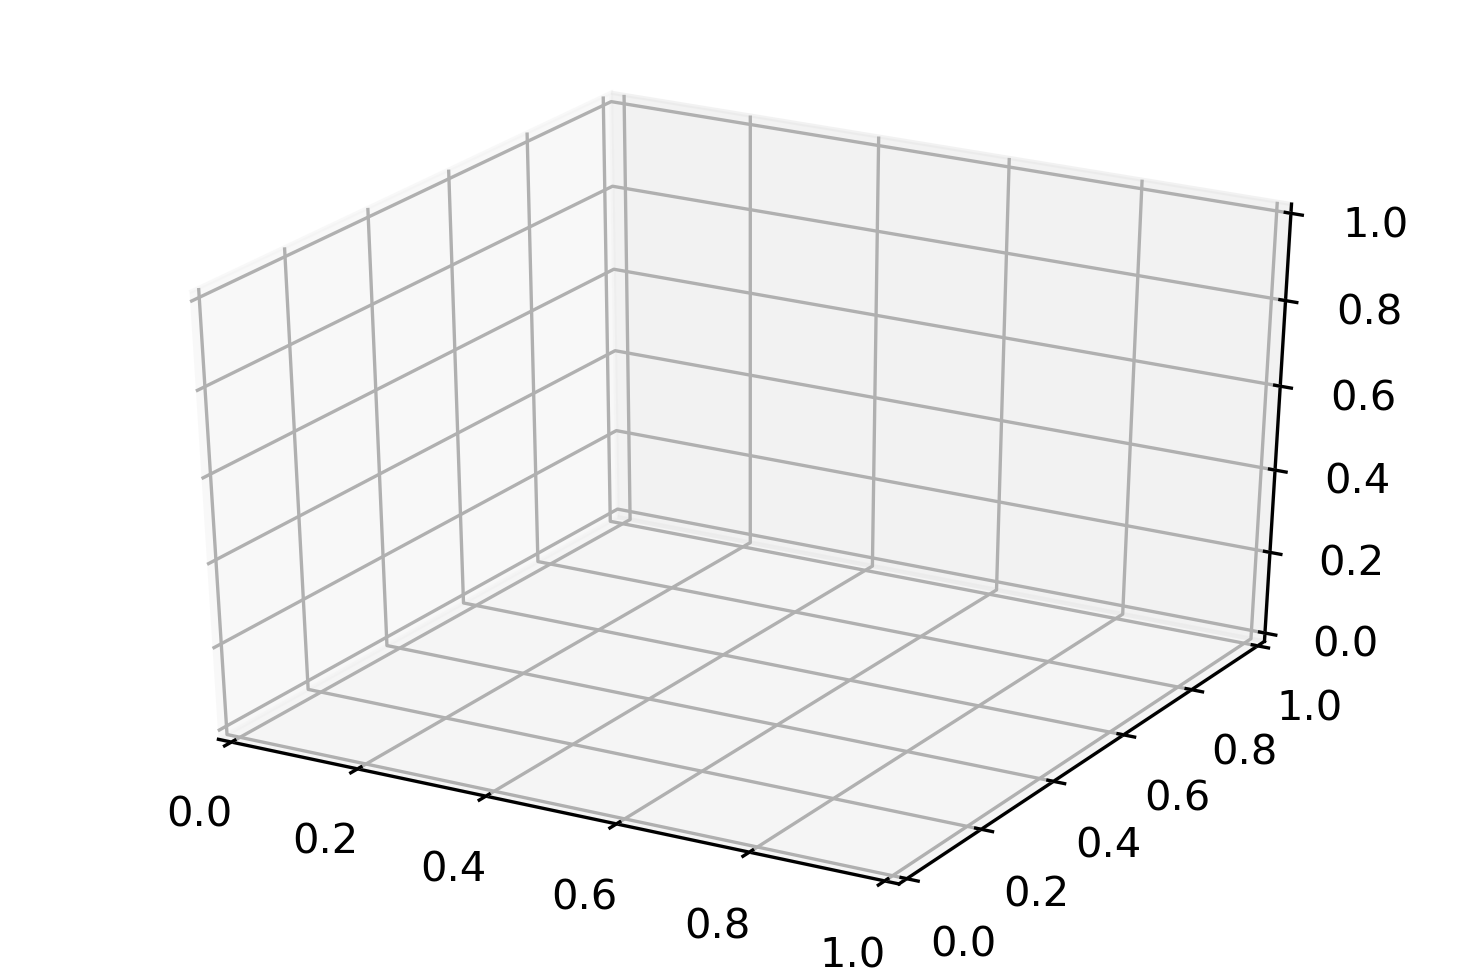

In [173]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

xs = x_r[_idx, 0]
ys = x_r[_idx, 1]
zs = x_r[_idx, 2]
ax.scatter(xs, ys, zs, c=y[_idx].ravel());

In [174]:
x_r.shape

(4906, 1)